(supervised:general:hyperparameter-tuning)=
# Hyperparameter Tuning

Hyperparameters are parameters of a model which are not fit to the data. Instead, they are choosen in advance, mainly to control model complexity. An example is the number of neighbors considered in k-NN method. But preprocessing steps may depend on parameters, too. Remember the number of components to keep in PCA, for instance. This is a hyperparameter of the overall model, too. In this broader sense a model is an algorithm which takes raw data and yields predictions.

Choice of hyperparameters is difficult and heavily builds upon experience of the data scientist. From the computational point of view it's very difficult to find optimal hyperparameters. Corresponding optimization problems are non-differentiable and, thus, not accessible to standard optimization procedures.

We will consider techniques for automatically choosing hyperparameters below. But getting some experience in manually choosing hyperparameters is an indispensable skill of data scientists.

## Pipelines

Scikit-Learn allows to combine several processing steps into one estimator object. Thus, applying a chain of transformations and fitting procedures to several data sets becomes very simple. This functionality is provided by the [`Pipeline` class](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) of the `sklearn.pipeline` module.

```{hint}
Pipelines aren't needed for hyperparameter optimization. But they simplify code by encapsulating all processing steps and their parameters in one Python object. Thus, hyperparameter optimization algorithms do not have to cope with several and different objects defining the overall model to be optimized.
```

Consider standardization followed by PCA and k-NN regression for the following example with synthetic data. We have three features and want to predict some quantity depending an these feature.

First the imports and creation of synthetic data.

In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng(0)

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d

import sklearn.preprocessing as preprocessing
import sklearn.decomposition as decomposition
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline

In [2]:
n = 1000    # number of data points to generate

# generate data
X = rng.multivariate_normal([1, 2, 3], [[1, 0.2, 0.3], [0.2, 2, -0.1], [0.3, -0.1, 0.2]], n)
y = (0.89 * X[:, 0] + 0.78 * X[:, 1] + 0.84 * X[:, 2] - 5.34) ** 2 + 0.5 * rng.normal(size=n)

# plot data (color encodes y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=3, c=y, cmap='jet')
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')
plt.show()

Now we create a pipeline containing all processing steps. The `Pipeline` constructor takes a list of tuples. Each tuple consists of a string and a Scikit-Learn object. The string will be used to refer to parts of the pipeline later on. The Scikit-Learn objects have to provide `fit` and `transform` methods, where the whole pipeline provides the same methods as the last object in the pipeline. Thus, if the last object provides a `predict` method, then the whole pipeline can be used for prediction.

In [3]:
steps = [('standardize', preprocessing.StandardScaler()),
         ('pca', decomposition.PCA(n_components=2)),
         ('knn', neighbors.KNeighborsRegressor(n_neighbors=5))]

pipe = pipeline.Pipeline(steps)

pipe.fit(X, y)
pipe.predict([[0, 0, 3]])

array([6.71318598])

Calling `fit` of the pipeline object calls `fit` and `transform` for the first object in the pipeling, then for the second, and so on. Parameters of the processing steps can be set when creating the objects or afterwards by calling `Pipeline.set_params()`. This method takes keyword arguments of the form `step__param`, where `step` is a step's name and `param` is the name of the parameter of the corresponding object.

In [4]:
pipe.set_params(knn__n_neighbors=10)
pipe.fit(X, y)
pipe.predict([[0, 0, 3]])

array([6.96541741])

All objects contained in a pipeline are accessible through the `Pipeline.steps` object. It's a list of tuples, each containing a step's name and the corresponding object. This way all parameters of all processing steps are available.

In [5]:
pipe.steps[1][1].components_[0, :]    # largest principal component

array([-0.70940987, -0.02120454, -0.70447712])

## Grid Search

The simplest but often also the only applicable form of hyperparameter optimization is grid search: for each hyperparameter we specify finitely many values and train a model for each combination of these values. Then the best model is chosen. To judge about a model's quality we need a scoring function, for regression problems usually the mean squared error on a validation set.

It's important to split the data into three sets: one for training the models, one for validating (that is, scoring) the models, and one for testing the final model's prediction quality on data not involved in the training and model selection process.

Splitting into training and validation data has not to be fixed. After having a closer look at grid search we will discuss advanced techniques for selecting training and validation data.

We start grid search with data splitting: 50% for training, 30% for validation, 20% for testing.

In [6]:
import sklearn.model_selection as model_selection

X_train_val, X_test, y_train_val, y_test \
    = model_selection.train_test_split(X, y, test_size=2/10, random_state=0)

X_train, X_val, y_train, y_val \
    = model_selection.train_test_split(X_train_val, y_train_val, test_size=3/8, random_state=0)

print(y_train.size, y_val.size, y_test.size)

500 300 200


Now steps are as follows:
* specify grid for each hyperparameter,
* generate all combinations of parameter values with [`ParameterGrid`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) from Scikit-Learn's `model_selection` module,
* loop over all combinations and find best model.

In [7]:
import sklearn.metrics as metrics

param_grid = {'pca__n_components': [1, 2, 3],
              'knn__n_neighbors': range(1, 11)}

best_err = None
best_params = None

for params in model_selection.ParameterGrid(param_grid):

    pipe.set_params(**params)
    pipe.fit(X_train, y_train)

    y_val_pred = pipe.predict(X_val)
    err = metrics.mean_squared_error(y_val_pred, y_val)

    if (best_err == None) or (err < best_err):
        best_err = err
        best_params = params
        
print(best_params)

{'knn__n_neighbors': 4, 'pca__n_components': 2}


Now we may fit the final model. Because we do not have to adjust hyperparameters anymore, we may **use both training and validation data for fitting**.

Metrics and plots demonstrate the performance of the model.

In [8]:
pipe.set_params(**best_params)
pipe.fit(X_train_val, y_train_val)

y_test_pred = pipe.predict(X_test)
mse = metrics.mean_squared_error(y_test_pred, y_test)

print('root of MSE:  ', np.sqrt(mse))
print('standard deviation of true targets:  ', np.std(y_test))

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 5))

s = y_test.argsort()    # sort for getting a continuous line
ax_left.plot(y_test[s], '-or', markersize=2, label='true targets')
ax_left.plot(y_test_pred[s], '-ob', markersize=2, label='predicted targets')
ax_left.set_xlabel('index')
ax_left.set_ylabel('targets')
ax_left.legend()

ax_right.plot(y_test, y_test_pred, 'ob', markersize=2)
min_value = np.minimum(y_test.min(), y_test_pred.min())
max_value = np.maximum(y_test.max(), y_test_pred.max())
ax_right.plot([min_value, max_value], [min_value, max_value], '-r')
ax_right.set_aspect('equal')
ax_right.set_xlabel('true targets')
ax_right.set_ylabel('predicted targets')

plt.show()

root of MSE:   1.4555318931691366
standard deviation of true targets:   4.641821625794403


## Cross Validation

Especially for small data sets different splits into training and validation sets may yield different results in hyperparameter optimization. To avoid influence of the splitting process, we may use many different splits and calculate their mean score. *Cross validation* implements this idea.

Data available for training and validation is split into $\nu$ more or less equally sized subsets. Then $\nu$ different training validation splits are considered: one of the $\nu$ subsets is used for validation and the other $\nu-1$ comprise the test set. For each such split we train the model and calculate the score on the validation set. Finally, we calculate the mean of all $\nu$ scores. This way all available data is used for training as well as for validation.

Scikit-Learn implements grid search with cross validation in the [`GridSearchCV` class](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). The constructor takes a Scikit-Learn object (a pipeline, for instance) and a parameter grid as arguments. `GridSearchCV` objects then provide a `fit` method for doing the grid search and a `predict` method for getting predictions from the optimal model. The constructur accepts several other important arguments:
* `scoring`: How to calculate the score for each model? The higher the score, the better the model. We may pass a predefined string, `'neg_mean_squared_error'`, for instance. See [list of predefined scoring parameters](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).
* `n_jobs`: How many processors to use? If Scikit-Learn shall use all available processors, pass `-1`.
* `cv`: How many subsets to use?. Typical choice are $2,\ldots,10$.

In [9]:
param_grid = {'pca__n_components': [1, 2, 3],
              'knn__n_neighbors': range(1, 11)}

gs = model_selection.GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
gs.fit(X_train_val, y_train_val)

y_test_pred = gs.predict(X_test)
mse = metrics.mean_squared_error(y_test_pred, y_test)

print(gs.best_params_)
print()
print('root of MSE:  ', np.sqrt(mse))
print('standard deviation of true targets:  ', np.std(y_test))

{'knn__n_neighbors': 3, 'pca__n_components': 2}

root of MSE:   1.4311176903230793
standard deviation of true targets:   4.641821625794403


If there are only very few samples for training and validation choosing as many subsets as samples are available can be useful. Then the validation set consists of only one sample. This approach is known as `leave one out (LOO) cross validation`.

## Randomized Search

If training of a model takes much time, then searching the whole parameter space for optimal hyperparameters via grid search is not feasible. In such cases choosing hyperparameters randomly may yield good results in less time. Scikit-Learn provides random search functionality with [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

## Bias versus Variance

There are two main sources for bad model performance:
* The model is too simple to properly represent the data.
* The model is overfitted to the training data.

In the first case we say that the model is too *biased*. That is, it contains assumptions about the data the data does not satisfy. Approximating nonlinear data by a linear function is a typical example.

The second situation stems from too complex models. The model itself imposes only very few assumptions on the data and gathers all its information from the training data. Here we say that the model has high *variance*. High variance results in low *generalization power*. That is, the model performance is bad on data not included in the training procedure.

To find good models we have to look for a compromise between bias and variance of a model. This is what we do when tuning hyperparameters. To reduce variance, obtaining more training data is a choice, too. But often getting more data is impossible or at least expensive.

Scikit-Learn has the [`learning_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) function to plot the dependence between size of training data set and prediction errors. The function trains and scores a model for different amounts of training data. For scoring cross validation is used.

In [10]:
pipe.set_params(pca__n_components=3, knn__n_neighbors=3)

train_sizes, train_scores, val_scores \
    = model_selection.learning_curve(pipe, X, y, train_sizes=np.linspace(0.1, 1, 20), cv=10,
                                     scoring='neg_mean_squared_error')

fig, ax = plt.subplots()
ax.plot(train_sizes, np.mean(train_scores, axis=1), '-ob', markersize=3, label='training scores')
ax.plot(train_sizes, np.mean(val_scores, axis=1), '-or', markersize=3, label='validation scores')
ax.legend()
ax.set_xlabel('size of training set')
ax.set_ylabel('score')
plt.show()

We see that 600 training samples suffice to train the model. Using more samples increases performance only slightly. Thus, it is very unlikely that collecting even more data would improve our model.

Similarly to the learning curve we may plot training and validation error depending on a hyperparameter. Usually, on the one end of the parameter scale the model is too simple (thus, high training and validation error), on the other end the model is too complex and overfits the training data (thus, low training error, high validation error). From the so called *validation plot* we may find a good hyperparameter between both extreme cases.

Scikit-Learn provides the [`validation_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html) function for this purpose. Usage is very similar to `learning_curve`.

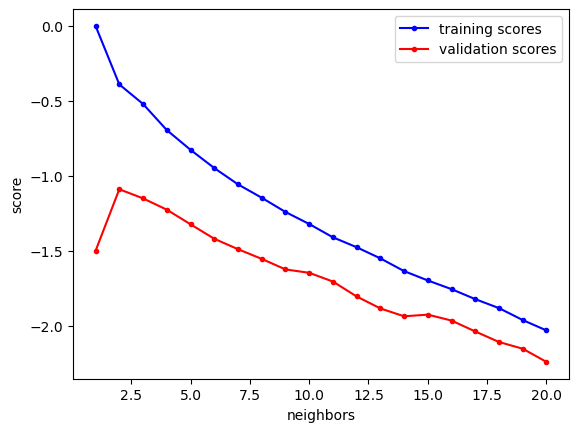

In [11]:
pipe.set_params(pca__n_components=3, knn__n_neighbors=3)

param_range = range(1, 21)
train_scores, val_scores \
    = model_selection.validation_curve(pipe, X, y, param_name='knn__n_neighbors',
                                       param_range=param_range, cv=10,
                                       scoring='neg_mean_squared_error')

fig, ax = plt.subplots()
ax.plot(param_range, np.mean(train_scores, axis=1), '-ob', markersize=3, label='training scores')
ax.plot(param_range, np.mean(val_scores, axis=1), '-or', markersize=3, label='validation scores')
ax.legend()
ax.set_xlabel('neighbors')
ax.set_ylabel('score')
plt.show()

Obviously, number of neighbors should be 2 to get a relatively good score (score close to 0 means that the mean squared error is close to 0). More neighbors reduce model complexity. Thus, the model isn't able to fit training (and validation) data. With only one neighbor the model tends to overfit training data.